In [2]:
import os

from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import get_stats, read_pickled_object

In [3]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 4

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [13]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))

X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()

# this is only available after running script 01 in notebook C
y_joint = pd.read_csv(os.path.join(data_path, 'processed',  'metastatic_potential_joint.csv'), index_col = 0)


When iterating through sample sizes, we will keep the test dataset size the same (maximum amount -- 20% of the full dataset). This is to ensure metric stability. 

We also subset N times per sample size to ensure stability.

In [ ]:
# set up manual fold params
n_splits = 10

fold_size = X.shape[0] // n_splits
train_samples_per_fold = int(np.round(X.shape[0] * ((100 - n_splits)/100)))

# prepare sample sizes
sample_sizes = np.arange(0.1,1.1, 0.1)

n_samples_iter = [int(np.round(train_samples_per_fold*sample_size)) for sample_size in sample_sizes]
if y_joint.shape[0] not in n_samples_iter:
    n_samples_iter.append(y_joint.shape[0]) # ensure the actualy join omics sample size is included
    n_samples_iter = sorted(n_samples_iter)

# subsets per sample size
n_subsets = 100

In [ ]:
res = pd.DataFrame(columns = ['fold', 'train_sample_size', 
                             'train_corr', 'test_corr', 'train_mse', 'test_mse'])

np.random.seed(random_state)
for k in range(n_splits):
    print(k)
    # manually get splits in order to ensure the are the same size across all folds
    shuffled_index = np.random.permutation(np.arange(X.shape[0]))
    train_idx = shuffled_index[:train_samples_per_fold]
    test_idx = shuffled_index[train_samples_per_fold:]
    
    X_train_full, X_test = X[train_idx], X[test_idx]
    y_train_full, y_test = y[train_idx], y[test_idx]
    
    for n_samples in n_samples_iter:
        if n_samples < train_samples_per_fold:
            for i in range(n_subsets):
                subset_idx = np.random.choice(train_samples_per_fold, n_samples, replace=False)
                X_train = X_train_full[subset_idx, :]
                y_train = y_train_full[subset_idx]

                train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train, y_test, X_train, X_test)

                res.loc[res.shape[0],:] = [k, n_samples, train_corr, test_corr, train_mse, test_mse]
        else:
            train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train_full, y_test, X_train_full, X_test)
            res.loc[res.shape[0],:] = [k, n_samples, train_corr, test_corr, train_mse, test_mse]
            
    res.to_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'))
            
            
            

In [4]:
res = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'), index_col = 0)

<Axes: xlabel='train_sample_size', ylabel='test_corr'>

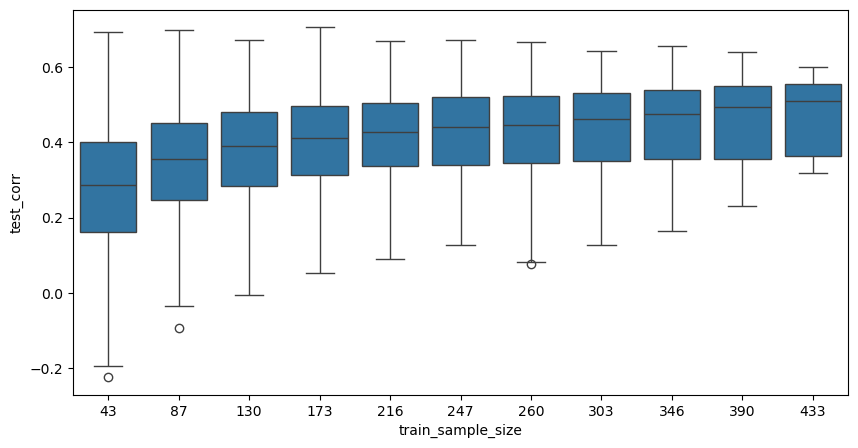

In [5]:
fig, ax = plt.subplots(figsize = (10,5))

sns.boxplot(data = res, x = 'train_sample_size', y = 'test_corr')

In [6]:
res.groupby('train_sample_size')['test_corr'].median()

train_sample_size
43     0.287465
87     0.356229
130    0.389205
173    0.411719
216    0.426523
247    0.441144
260    0.446577
303    0.462566
346    0.475902
390    0.493869
433    0.510644
Name: test_corr, dtype: float64

Let's compare the sample size of the join transcriptomics/proteomics to that of the power analysis in just the transcriptomics:

In [33]:
def cohen_d(vector_1, vector_2):
    # Calculate the means of the two vectors
    mean1 = np.mean(vector_1)
    mean2 = np.mean(vector_2)

    # Calculate the standard deviations of the two vectors
    std1 = np.std(vector_1, ddof=1)
    std2 = np.std(vector_2, ddof=1)

    # Calculate the pooled standard deviation
    n1 = len(vector_1)
    n2 = len(vector_2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

In [15]:
rna_res = res[res.train_sample_size == y_joint.shape[0]]
joint_res = pd.read_csv(os.path.join(data_path, 'processed', 'consensus_model_res_joint.csv'), 
                       index_col = 0)

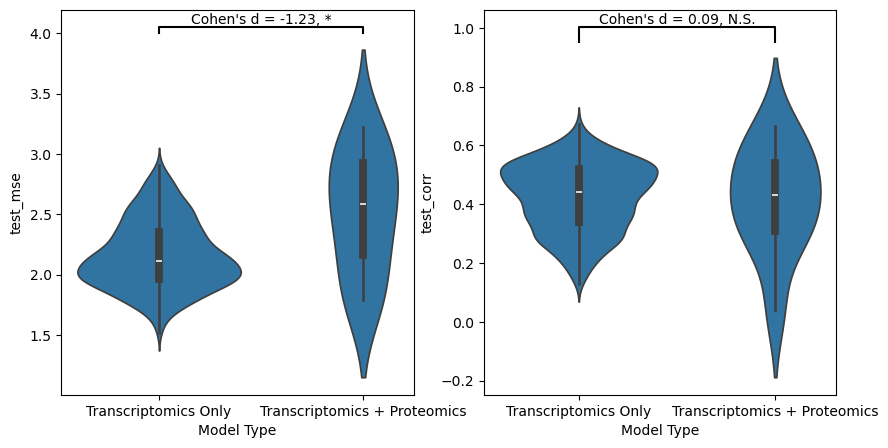

In [43]:
metric_types = ['mse', 'corr']

fig, ax = plt.subplots(figsize = (10,5), ncols = len(metric_types))


for i, metric_type in enumerate(metric_types):
    rna_viz = pd.DataFrame(rna_res['test_' + metric_type])
    rna_viz['Model Type'] = 'Transcriptomics Only'

    joint_viz = pd.DataFrame(joint_res['test_' + metric_type])
    joint_viz['Model Type'] = 'Transcriptomics + Proteomics'

    viz_df = pd.concat([rna_viz, joint_viz], axis = 0)
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = 'test_' + metric_type, ax = ax[i])
    
    p_value = stats.mannwhitneyu(rna_res['test_' + metric_type], joint_res['test_' + metric_type]).pvalue
    cd = cohen_d(rna_res['test_' + metric_type], joint_res['test_' + metric_type])
    
    significance = "N.S."
    if p_value <= 1e-4:
        significance = "****"
    elif p_value <= 0.001:
        significance = "***"
    elif p_value <= 0.01:
        significance = "**"
    elif p_value <= 0.1:
        significance = "*"
        
    x1, x2 = 0, 1  # x positions for the groups
    y, h = ax[i].get_ylim()[1], 0.05  # y position and height for the bar
    ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')  # Draw the bar
    ax[i].text((x1 + x2)/2, y + h, f"Cohen's d = {cd:.2f}, " + significance, 
            ha='center', va='bottom', fontsize=10)
            


There is no difference in the performance as assessed by Pearson correlation, and in fact, as assessed by MSE, the transcriptomics only model performs slightly better.